In [1]:
import cudf
import pandas as pd
import os

In [2]:
!nvidia-smi

Mon Feb 24 02:39:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              2W /   40W |      12MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
path = "/home/suhani/Downloads/archive/yellow_tripdata_2016-03.csv"

In [4]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          48 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   16
  On-line CPU(s) list:    0-15
Vendor ID:                AuthenticAMD
  Model name:             AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
    CPU family:           25
    Model:                116
    Thread(s) per core:   2
    Core(s) per socket:   8
    Socket(s):            1
    Stepping:             1
    CPU(s) scaling MHz:   22%
    CPU max MHz:          5137.0000
    CPU min MHz:          400.0000
    BogoMIPS:             7586.46
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall
                           nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep
                          _good amd_lbr_v2 nopl nonstop_tsc cpuid extd_apicid ap
                          er

In [5]:
import time

In [6]:
pd_load_times = []

for _ in range(5):
    start = time.time()
    df_pd = pd.read_csv(path)
    pd_load_times.append(time.time()-start)

avg_pd_load_time = sum(pd_load_times)/len(pd_load_times)

In [7]:
cudf_load_times = []

for _ in range(5):
    start = time.time()
    df_cudf = cudf.read_csv(path)
    cudf_load_times.append(time.time()-start)
    
avg_cudf_load_time = sum(cudf_load_times)/len(cudf_load_times)

In [8]:
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo

nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)

print(f"Total Memory: {info.total / 1024**3:.2f} GB")
print(f"Free Memory: {info.free / 1024**3:.2f} GB")
print(f"Used Memory: {info.used / 1024**3:.2f} GB")


Total Memory: 8.00 GB
Free Memory: 5.58 GB
Used Memory: 2.41 GB


In [9]:
print(f"Average Pandas load time: {avg_pd_load_time:.2f}s")
print(f"Average cuDF load time: {avg_cudf_load_time:.2f}s")

Average Pandas load time: 15.13s
Average cuDF load time: 1.12s


In [10]:
pd_filter_times = []

for _ in range(5):
    start = time.time()
    filt = df_pd[df_pd['passenger_count'] > 2] 
    pd_filter_times.append(time.time()-start)

In [24]:
avg_pd_filter_time = sum(pd_filter_times)/len(pd_filter_times)

In [12]:
cudf_filter_times = []

for _ in range(5):
    start = time.time()
    filt = df_cudf[df_cudf['passenger_count'] > 2] 
    cudf_filter_times.append(time.time()-start)

In [25]:
avg_cudf_filter_time = sum(cudf_filter_times)/len(cudf_filter_times)

In [14]:
df_pd_subset = df_pd.head(1000)
df_cudf_subset = df_cudf.head(1000)
print(df_pd.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [15]:
pd_merge_times = []

for _ in range(5):
    start = time.time()
    mrg = pd.merge(df_pd_subset,df_pd_subset,on='VendorID')
    pd_merge_times.append(time.time()-start)

avg_pd_merge_time = sum(pd_merge_times)/len(pd_merge_times)

In [16]:
cudf_merge_times = []

for _ in range(5):
    start = time.time()
    mrg = cudf.merge(df_cudf_subset,df_cudf_subset,on='VendorID')
    cudf_merge_times.append(time.time()-start)

avg_cudf_merge_time = sum(cudf_merge_times)/len(cudf_merge_times)

In [17]:
print(avg_pd_merge_time)
print(avg_cudf_merge_time)

0.13312773704528807
0.01996917724609375


In [18]:
pd_group_times = []

for _ in range(5):
    start = time.time()
    grouped_pd = df_pd.groupby('passenger_count')['fare_amount'].mean()
    pd_group_times.append(time.time()-start)

avg_pd_group_time = sum(pd_group_times)/len(pd_group_times)

In [19]:
cudf_group_times = []

for _ in range(5):
    start = time.time()
    grouped_cudf = df_cudf.groupby('passenger_count')['fare_amount'].mean()
    cudf_group_times.append(time.time()-start)

avg_cudf_group_time = sum(cudf_group_times)/len(cudf_group_times)

In [20]:
print(avg_pd_group_time)
print(avg_cudf_group_time)

0.11287260055541992
0.02339310646057129


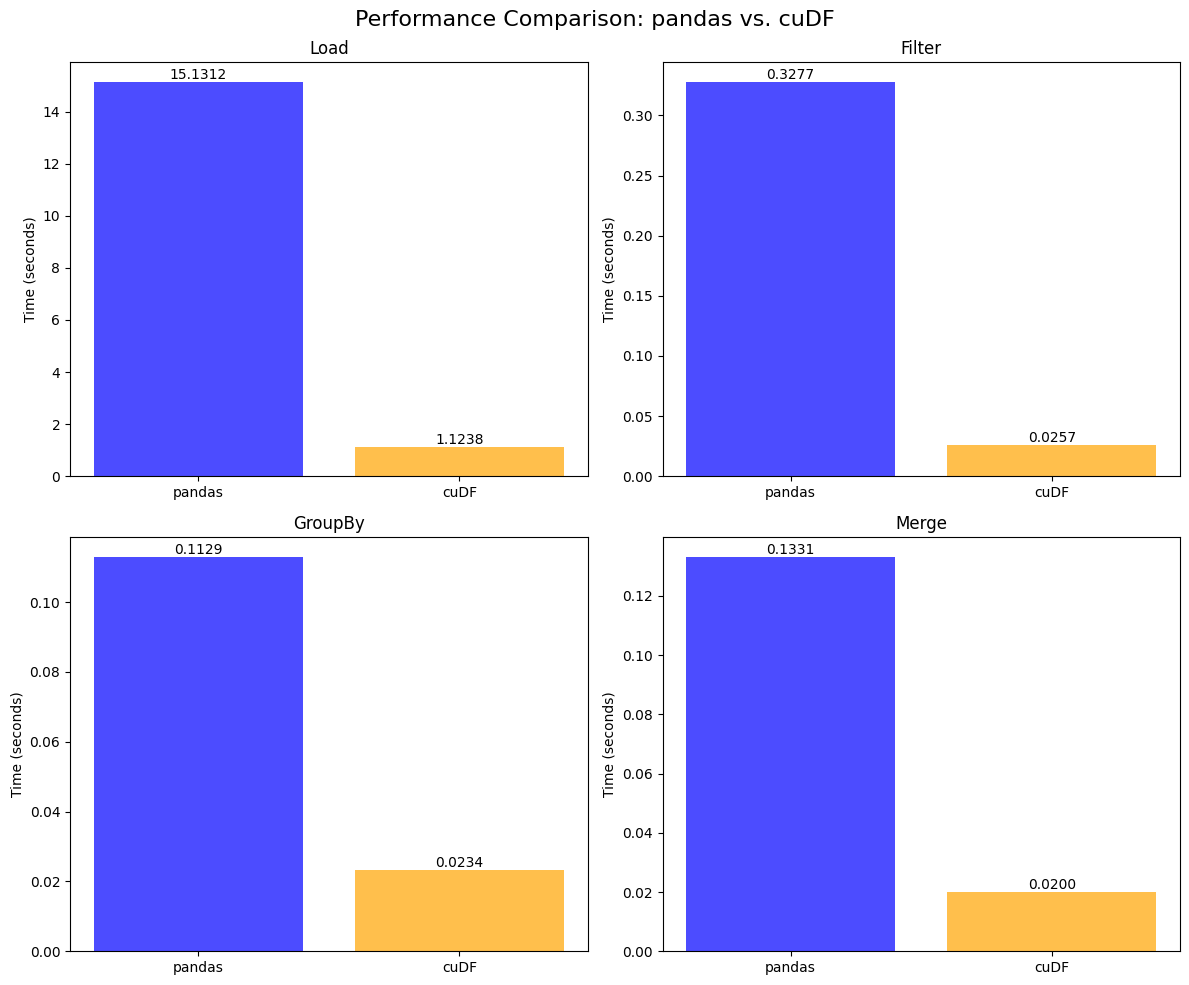

In [37]:
import matplotlib.pyplot as plt

operations = ['Load', 'Filter', 'GroupBy', 'Merge']
pandas_times = [avg_pd_load_time, avg_pd_filter_time, avg_pd_group_time, avg_pd_merge_time]
cudf_times = [avg_cudf_load_time, avg_cudf_filter_time, avg_cudf_group_time, avg_cudf_merge_time]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Performance Comparison: pandas vs. cuDF", fontsize=16)

for i, operation in enumerate(operations):
    ax = axs[i // 2, i % 2]
    x = ['pandas', 'cuDF']
    y = [pandas_times[i], cudf_times[i]]
    
    ax.bar(x, y, color=['blue', 'orange'], alpha=0.7)
    ax.set_title(operation)
    ax.set_ylabel("Time (seconds)")
    
    for j, v in enumerate(y):
        ax.text(j, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('foo.png')
plt.show()


In [2]:
import subprocess
import time
import threading
import matplotlib.pyplot as plt
import cudf
from pynvml import *

class GPUMemoryMonitor:
    def __init__(self, interval=0.1):
        self.interval = interval
        self.timestamps = []
        self.memory_usage = []
        self.gpu_utilization = []
        self.running = False
        self.thread = None
        self.start_time = None

    def _monitor(self):
        self.start_time = time.time()
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(0)  # Assuming one GPU; adjust for multi-GPU
        while self.running:
            try:
                # Get GPU memory usage
                mem_info = nvmlDeviceGetMemoryInfo(handle)
                memory_used = mem_info.used / (1024**2)  # Convert to MB

                # Get GPU utilization
                utilization = nvmlDeviceGetUtilizationRates(handle).gpu
            except Exception as e:
                memory_used = 0
                utilization = 0
            elapsed = time.time() - self.start_time
            self.timestamps.append(elapsed)
            self.memory_usage.append(memory_used)
            self.gpu_utilization.append(utilization)
            time.sleep(self.interval)

    def start(self):
        self.running = True
        self.thread = threading.Thread(target=self._monitor)
        self.thread.start()

    def stop(self):
        self.running = False
        if self.thread:
            self.thread.join()

monitor = GPUMemoryMonitor(interval=0.1)
monitor.start()

while monitor.start_time is None:
    time.sleep(0.001)

path = "/home/suhani/Downloads/archive/yellow_tripdata_2016-03.csv"

operation_points = []
def log_operation(name):
    op_time = time.time() - monitor.start_time
    operation_points.append((op_time, name))

log_operation("Start read_csv")
start_read = time.time()
df_cudf = cudf.read_csv(path)
end_read = time.time()
log_operation("End read_csv")

log_operation("Start filter")
start_filter = time.time()
filtered_cudf = df_cudf[df_cudf['passenger_count'] > 2]
end_filter = time.time()
log_operation("End filter")

log_operation("Start groupby")
start_groupby = time.time()
grouped_cudf = filtered_cudf.groupby('passenger_count')['fare_amount'].mean()
end_groupby = time.time()
log_operation("End groupby")

monitor.stop()

plt.figure(figsize=(12, 6))
plt.plot(monitor.timestamps, monitor.memory_usage, label='GPU Memory Usage (MB)')
plt.plot(monitor.timestamps, monitor.gpu_utilization, label='GPU Utilization (%)')  # Plot utilization
plt.xlabel('Time (seconds)')
plt.ylabel('MBs')
plt.title('GPU Memory Usage and Utilization During cuDF Operations')

op_times = [op_time for op_time, _ in operation_points]
op_names = [op_name for _, op_name in operation_points]
plt.xticks(op_times, op_names, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'cudf'